## Machine Learning - Assignment 1

### Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:

Pre-process the dataset.
Identify outliers.
Check the correlation.
Implement linear regression and random forest regression models.
Evaluate the models and compare their respective scores like R2, RMSE, etc. Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

sns.set_theme(style="whitegrid",font_scale = 1.5)
%matplotlib inline

In [15]:
raw_data=pd.read_csv('uber.csv')

### Make a copy of data for analysis

In [16]:
data=raw_data.copy(deep=True)
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [18]:
data.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

### Drop null values

In [19]:
data=data.dropna()
data.isna().sum().sum()

0

In [20]:
data.describe(exclude="object")

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999990e+05,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,2.771248e+07,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,1.601386e+07,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382534e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774524e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155535e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


### Convert datatype of columns

In [21]:
data['key']=data['key'].astype('datetime64')

In [22]:
data['pickup_datetime']=data['pickup_datetime'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S UTC"))

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         199999 non-null  int64         
 1   key                199999 non-null  datetime64[ns]
 2   fare_amount        199999 non-null  float64       
 3   pickup_datetime    199999 non-null  datetime64[ns]
 4   pickup_longitude   199999 non-null  float64       
 5   pickup_latitude    199999 non-null  float64       
 6   dropoff_longitude  199999 non-null  float64       
 7   dropoff_latitude   199999 non-null  float64       
 8   passenger_count    199999 non-null  int64         
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 15.3 MB


### Create new column of distance using pickup ad drop off locations

In [24]:
from math import radians, sin, cos, acos
def calculateDist(src_lat,src_long,dest_lat,dest_long):
    slat=radians(src_lat)
    slon=radians(src_long)
    elat=radians(dest_lat)
    elon=radians(dest_long)
    #print(slat,slon,elat,elon,sep='\t')
    if slat==elat and slon==elon:
        return 0
    
    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    
    return dist

In [25]:
data['distance']=data.apply(lambda row: calculateDist(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']), axis = 1)
 

In [26]:
data[['distance','fare_amount','passenger_count']].describe()

,distance,fare_amount,passenger_count
count,199999.000000,199999.000000,199999.000000
mean,20.855383,11.359892,1.684543
std,382.965243,9.901760,1.385995
min,0.000000,-52.000000,0.000000
25%,1.215224,6.000000,1.000000
50%,2.120996,8.500000,1.000000
75%,3.875175,12.500000,2.000000
max,16409.264891,499.000000,208.000000


### Visualize Data

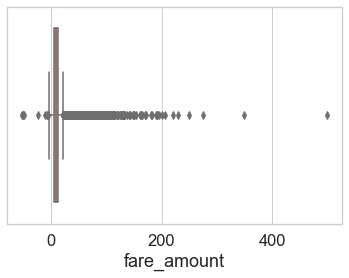

In [27]:
sns.boxplot(data=data,x='fare_amount',color='lightcoral')
plt.show()

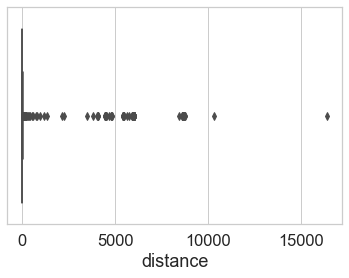

In [28]:
sns.boxplot(x=data['distance'])
plt.show()

### Find outliers in data

In [29]:
df=data

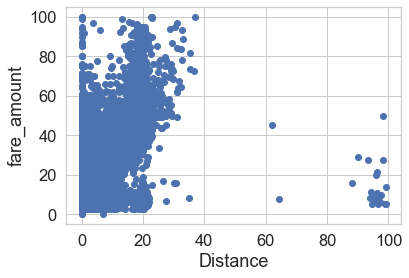

In [30]:
#Dealing with Outliers via removing rows with too large Distance and 0 or lesser distance.
df.drop(df[df['distance']>100].index, inplace=True)
df.drop(df[df['distance']==0].index, inplace=True)
df.drop(df[df['distance']<0].index, inplace=True)
#Dealing with Outliers via removing rows with 0 or lesser fare amounts.
df.drop(df[df['fare_amount']==0].index, inplace=True)
df.drop(df[df['fare_amount']<0].index, inplace=True)
#Dealing with Outliers via removing passengers more than 5
df.drop(df[df['passenger_count']>5].index, inplace=True)
#Dealing with Outliers via removing rows with non-plausible fare amounts and distance travelled.
df.drop(df[df['distance']>100].index, inplace=True)
df.drop(df[df['fare_amount']>100].index, inplace=True)
df.drop(df[(df['fare_amount']>100) & (df['distance']<1)].index, inplace = True )
df.drop(df[(df['fare_amount']<100) & (df['distance']>100)].index, inplace = True )
#Plotting a Scatter Plot to check for any more outliers and also to show correlation between Fare Amount and Distance.
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")
plt.show()

### Add new Columns

In [31]:
df.rename(columns={'Unnamed: 0':'id'}, inplace=True)               # renaming unnamed column
df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'])      # changing datatype to datetime
df['day']     = df['pickup_datetime'].apply(lambda x:x.day)
df['hour']    = df['pickup_datetime'].apply(lambda x:x.hour)
df['weekday'] = df['pickup_datetime'].apply(lambda x:x.isoweekday())
df['month']   = df['pickup_datetime'].apply(lambda x:x.month)
df['year']    = df['pickup_datetime'].apply(lambda x:x.year)
df.head()


,id,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,hour,weekday,month,year
0,24238194,2015-05-07 19:52:06.000000300,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,7,19,4,5,2015
1,27835199,2009-07-17 20:04:56.000000200,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2.457594,17,20,5,7,2009
2,44984355,2009-08-24 21:45:00.000000610,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036385,24,21,1,8,2009
3,25894730,2009-06-26 08:22:21.000000100,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,26,8,5,6,2009
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475457,28,17,4,8,2014


In [32]:
data=df

### Train models

In [33]:
def train_model(model,x_train,y_train,x_test,y_test):
    
    model_lin1=model.fit(x_train,y_train)
    price_pred=model_lin1.predict(x_test)

    # RMSE
    lin_rmse1=np.sqrt(mean_squared_error(y_test,price_pred))
    print('RMSE = ',lin_rmse1)

    # R Sq value
    r2_lin_test1=model_lin1.score(x_test,y_test)
    r2_lin_train1=model_lin1.score(x_train,y_train)
    print('\nR Squares Value - \nTest\t\t\tTrain\n',r2_lin_test1,'\t',r2_lin_train1)

    
    return model_lin1,lin_rmse1,r2_lin_test1,r2_lin_train1


In [34]:
X=data[['distance','passenger_count','distance','day','hour','weekday','month','year']]
Y=data[['fare_amount']]


In [35]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=0,test_size=0.3)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape,sep='\n')

(132755, 8)
(132755, 1)
(56895, 8)
(56895, 1)


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [37]:
lr = LinearRegression()
model,rmse,rt_tr,r_ts=train_model(lr,x_train,y_train,x_test,y_test)

RMSE =  4.602019346452159

R Squares Value - 
Test			Train
 0.7536843656044809 	 0.7420172103700151


In [38]:
#Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=10)
model,rmse,rt_tr,r_ts=train_model(rf,x_train,y_train,x_test,y_test)

C:\Users\L470_2\AppData\Local\Temp\ipykernel_6448\1631838728.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_lin1=model.fit(x_train,y_train)


RMSE =  3.8953679483555197

R Squares Value - 
Test			Train
 0.8235213911856443 	 0.97441821794461
